
=== Model Performance ===
Accuracy: 0.8842
F1 Score: 0.5333
ROC-AUC: 0.8843

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       565
           1       0.68      0.44      0.53       100

    accuracy                           0.88       665
   macro avg       0.79      0.70      0.73       665
weighted avg       0.87      0.88      0.87       665



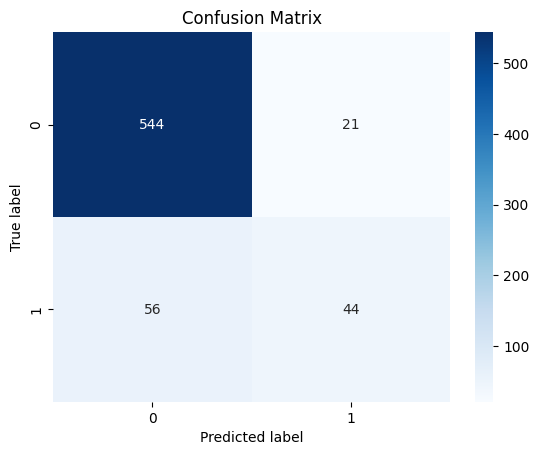

<Figure size 1000x800 with 0 Axes>

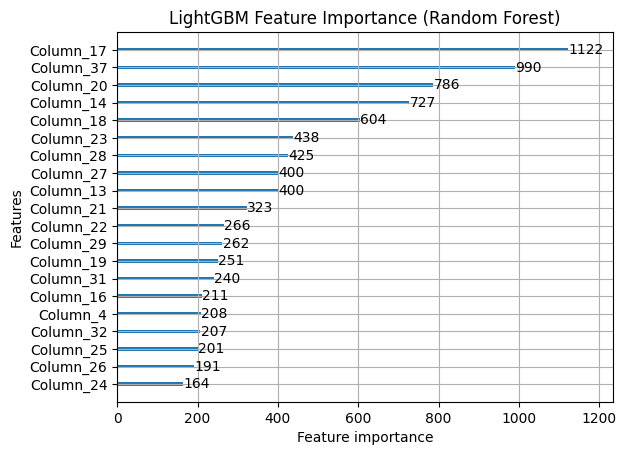

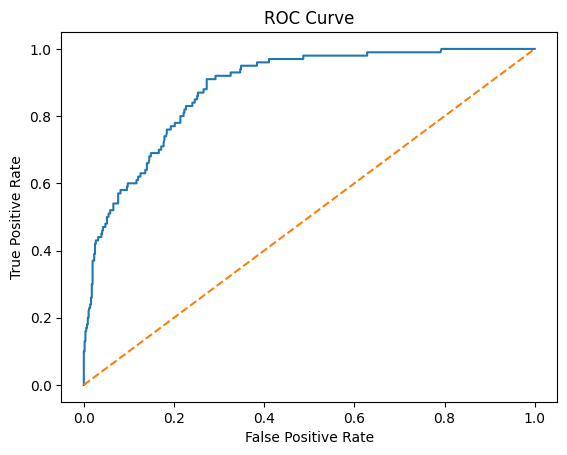

In [8]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

df = pd.read_csv("marketing_campaign.csv", sep="\t")

df = df[df["Income"].notnull()]

df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], format="%d-%m-%Y")
df["Customer_Since_Days"] = (df["Dt_Customer"].max() - df["Dt_Customer"]).dt.days

df = df.drop(columns=["ID", "Dt_Customer"])

# Define target & features
target = "Response"
X = df.drop(columns=[target])
y = df[target]

# Identify categorical and numeric features
categorical_features = ["Education", "Marital_Status"]
numeric_features = [col for col in X.columns if col not in categorical_features]

# Preprocessing: One-hot encode categoricals
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)

# LightGBM Random Forest model
lgb_rf_params = {
    "boosting_type": "rf",
    "num_leaves": 31,
    "max_depth": -1,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "feature_fraction": 0.8,
    "objective": "binary",
    "metric": "binary_logloss",
    "n_estimators": 300,
    "verbose": -1,
    "force_col_wise": True
}

model = lgb.LGBMClassifier(**lgb_rf_params)

# Create full pipeline
pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Train model
pipeline.fit(X_train, y_train)

# Evaluation
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\n=== Model Performance ===")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {auc:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

# Feature importance
lgb_model = pipeline.named_steps["model"]
plt.figure(figsize=(10, 8))
lgb.plot_importance(lgb_model, max_num_features=20)
plt.title("LightGBM Feature Importance (Random Forest)")
plt.show()

# ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()
